<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Practice/pr2/Practice2_PixelCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone --single-branch --branch main https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 90 (delta 28), reused 53 (delta 14), pack-reused 0
Unpacking objects: 100% (90/90), done.
renamed 'dul_2021/Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'dul_2021/Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'dul_2021/Homework/hw1/data/mnist_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist.pkl' -> 'dul_2021/Homework/hw1/data/mnist.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'dul_2021/Homework/hw1/data/shapes_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes.pkl' -> 'dul_2021/Homework/hw1/data/shapes.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/smiley.jpg' -> 'dul_2021/Homework/hw1/data/smiley.jpg'
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to b

In [2]:
from dul_2021.utils.pr2_utils import *

# Question 1 PixelCNNs

## Part (a) PixelCNN on Shapes and MNIST
In this part, we implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as HW1(b), but with a PixelCNN).

Network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

With the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 20 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

<!-- **You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model -->



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [3]:
import os
import numpy as np
import copy
from itertools import chain

import torch
import torch.nn as nn
import torch.optim as opt
from torch.autograd import Variable
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import DataLoader

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class MaskedConv(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.set_mask()
    
    def forward(self, x):
        # self.weight.data *= mask
        return F.conv2d(x, self.mask * self.weight, bias=self.bias, stride=self.stride, padding=self.padding)

    def set_mask(self):
        raise NotImplementedError()

In [6]:
class ConvA(MaskedConv):
    def set_mask(self):
        h, w = self.kernel_size
        self.mask[:, :, h // 2, : w // 2] = 1
        self.mask[:, :, :h // 2] = 1
    
class ConvB(MaskedConv):
    def set_mask(self):
        h, w = self.kernel_size
        self.mask[:, :, h // 2, : w // 2 + 1] = 1
        self.mask[:, :, :h // 2] = 1

In [7]:
class PixelCNN(nn.Module):
    def __init__(self, input_shape, cf=64):
        super().__init__()
        self.input_shape = input_shape

        self.model = nn.Sequential(ConvA(1, cf, 7, 1, 3), nn.ReLU(), 
                                   ConvB(cf, cf, 7, 1, 3), nn.ReLU(), 
                                   ConvB(cf, cf, 7, 1, 3), nn.ReLU(),
                                   ConvB(cf, cf, 7, 1, 3), nn.ReLU(),
                                   ConvB(cf, cf, 7, 1, 3), nn.ReLU(),
                                   ConvB(cf, cf, 7, 1, 3), nn.ReLU(),
                                   ConvB(cf, cf, 1), nn.ReLU(), 
                                   ConvB(cf, 1, 1), nn.Sigmoid())
        
    
    def nll(self, x):
        return F.binary_cross_entropy(self.model(x), x)

    def test(self, testloader):
        with torch.no_grad():
            loss = 0
            tc = 0
            for batch in testloader:
                loss = self.nll(batch.to(device).float()) * batch.shape[0]
                tc += batch.shape[0]
            return loss / tc
                

    def fit(self, train_data, test_data, num_epochs=20, lr=1e-3, batch_size=128):

        trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        testloader = DataLoader(test_data, batch_size=batch_size)

        train_loss = []
        test_loss = []

        optim = opt.Adam(self.parameters(), lr=lr)

        test_loss.append(self.test(testloader))

        for epoch in range(num_epochs):
            for batch in trainloader:
                loss = self.nll(batch.to(device).float())
                optim.zero_grad()
                loss.backward()
                optim.step()

                train_loss.append(loss.cpu().data)

            test_loss.append(self.test(testloader))
        
        return train_loss, test_loss

    def sample(self, n=100):
        with torch.no_grad():
            samples = torch.zeros(n, 1, *self.input_shape).to(device)

            for i in range(self.input_shape[0]):
                for j in range(self.input_shape[1]):
                    probs = self.model(samples)[:, 0, i, j]
                    samples[:, 0, i, j] = torch.bernoulli(probs)
            return samples.cpu().detach().numpy().transpose(0, 2, 3, 1)



In [8]:
def pr1(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    train_data = train_data.transpose(0, 3, 1, 2)
    test_data  = test_data.transpose(0, 3, 1, 2)

    model = PixelCNN(image_shape).to(device)

    tr_loss, te_loss = model.fit(train_data, test_data)

    samples = model.sample()


    return tr_loss, te_loss, samples

### Results


Final Test Loss: 0.0001


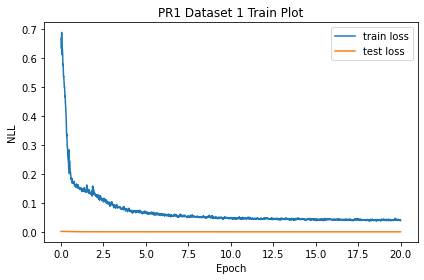

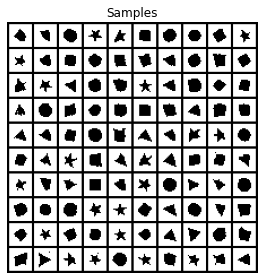

In [9]:
pr1_save_results(1, pr1)

Final Test Loss: 0.0785


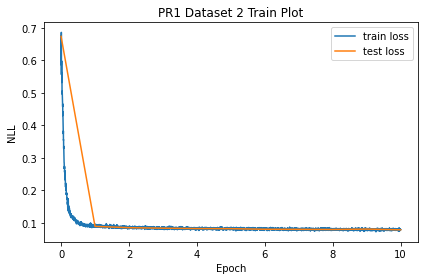

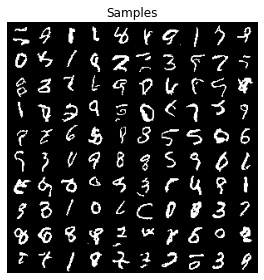

In [ ]:
pr1_save_results(2, pr1) # 26 minutues